In [ ]:
import pandas as pd
import importlib
import mne
import numpy as np

from typing import List, Optional
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

import EpilepsyNet_model 


epoch_duration = 5.0

# Make Balanced datasets

In [3]:
def Load_raw_labeled(df):
    """
    Load the raw EEG data and labels from the dataframe.
    """
    raw_list = []
    labels = []
    for index, row in df.iterrows():
        # Load the raw EEG data
        raw = mne.io.read_raw_edf(row['edf_path'], preload=True, verbose='ERROR')
        # Append the loaded data and label to the lists
        if raw.duration>60:
            raw_list.append(raw)
            labels.append(row['epilepsy'])
        else:
            print(f"Skipping {row['edf_path']} due to insufficient duration. Duration: {raw.duration} seconds")
    return raw_list, labels

In [4]:
df = pd.read_excel('eeg_metadata.xlsx')
df['epilepsy'] = df['edf_path'].apply(lambda x: 0 if 'no_epilepsy' in x else 1)
try:
    df.drop(['Unnamed: 0', 'ethnicity'], axis=1, inplace=True)
except:
    pass
df

,edf_path,subject_id,session,session_date,montage,token,patient_group,age,gender,epilepsy
0,EEG_Epilepsy/00_epilepsy/aaaaaoui/s002_2013/01...,aaaaaoui,s002,2013,01_tcp_ar,t001,epilepsy,56,M,1
1,EEG_Epilepsy/00_epilepsy/aaaaaoui/s001_2013/01...,aaaaaoui,s001,2013,01_tcp_ar,t000,epilepsy,56,M,1
2,EEG_Epilepsy/00_epilepsy/aaaaaoui/s001_2013/01...,aaaaaoui,s001,2013,01_tcp_ar,t001,epilepsy,56,M,1
3,EEG_Epilepsy/00_epilepsy/aaaaakvr/s001_2010/01...,aaaaakvr,s001,2010,01_tcp_ar,t000,epilepsy,43,F,1
4,EEG_Epilepsy/00_epilepsy/aaaaamys/s001_2012/01...,aaaaamys,s001,2012,01_tcp_ar,t000,epilepsy,44,M,1
...,...,...,...,...,...,...,...,...,...,...
2293,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s002_2012...,aaaaangg,s002,2012,01_tcp_ar,t011,no_epilepsy,57,M,0
2294,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s002_2012...,aaaaangg,s002,2012,01_tcp_ar,t005,no_epilepsy,57,M,0
2295,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s001_2012...,aaaaangg,s001,2012,01_tcp_ar,t001,no_epilepsy,57,M,0
2296,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s001_2012...,aaaaangg,s001,2012,01_tcp_ar,t000,no_epilepsy,57,M,0


In [5]:
for i in range(200,210):
    print(f"\'{df['edf_path'][i]}\',")

'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t005.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t011.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t010.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t004.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t012.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t006.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t007.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t009.edf',
'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t008.edf',
'EEG_Epilepsy/00_epilepsy/aaaaanwn/s003_2014/01_tcp_ar/aaaaanwn_s003_t001.edf',


In [6]:
df_pos = df[df['epilepsy'] == 1]
df_neg = df[df['epilepsy'] == 0]

print(df_pos['subject_id'].nunique(), df_neg['subject_id'].nunique())
split_pos = int(0.8 * len(df_pos['subject_id'].unique()))
print(split_pos)

split_train_pos, split_test_pos = df_pos['subject_id'].unique()[:split_pos], df_pos['subject_id'].unique()[split_pos:]

print(len(split_train_pos ), len(split_test_pos ))
##############################
split_neg = int(0.8 * len(df_neg['subject_id'].unique()))
print(split_neg)

split_train_neg, split_test_neg = df_neg['subject_id'].unique()[:split_neg], df_neg['subject_id'].unique()[split_neg:]

print(len(split_train_neg), len(split_test_neg))


100 100
80
80 20
80
80 20


In [7]:
df_train = pd.concat([df_pos[df_pos['subject_id'].isin(split_train_pos)], df_neg[df_neg['subject_id'].isin(split_train_neg)]])
print(df_train.shape, df_train['epilepsy'].value_counts())
display(df_train)

df_test = pd.concat([df_pos[df_pos['subject_id'].isin(split_test_pos)], df_neg[df_neg['subject_id'].isin(split_test_neg)]])
print(df_test.shape, df_test['epilepsy'].value_counts())
display(df_test)

(1894, 10) epilepsy
1    1464
0     430
Name: count, dtype: int64


,edf_path,subject_id,session,session_date,montage,token,patient_group,age,gender,epilepsy
0,EEG_Epilepsy/00_epilepsy/aaaaaoui/s002_2013/01...,aaaaaoui,s002,2013,01_tcp_ar,t001,epilepsy,56,M,1
1,EEG_Epilepsy/00_epilepsy/aaaaaoui/s001_2013/01...,aaaaaoui,s001,2013,01_tcp_ar,t000,epilepsy,56,M,1
2,EEG_Epilepsy/00_epilepsy/aaaaaoui/s001_2013/01...,aaaaaoui,s001,2013,01_tcp_ar,t001,epilepsy,56,M,1
3,EEG_Epilepsy/00_epilepsy/aaaaakvr/s001_2010/01...,aaaaakvr,s001,2010,01_tcp_ar,t000,epilepsy,43,F,1
4,EEG_Epilepsy/00_epilepsy/aaaaamys/s001_2012/01...,aaaaamys,s001,2012,01_tcp_ar,t000,epilepsy,44,M,1
...,...,...,...,...,...,...,...,...,...,...
2210,EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s002_2011...,aaaaalpi,s002,2011,02_tcp_le,t002,no_epilepsy,29,M,0
2211,EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s002_2011...,aaaaalpi,s002,2011,02_tcp_le,t003,no_epilepsy,29,M,0
2212,EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s002_2011...,aaaaalpi,s002,2011,02_tcp_le,t004,no_epilepsy,29,M,0
2213,EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s002_2011...,aaaaalpi,s002,2011,02_tcp_le,t005,no_epilepsy,29,M,0


(404, 10) epilepsy
1    321
0     83
Name: count, dtype: int64


,edf_path,subject_id,session,session_date,montage,token,patient_group,age,gender,epilepsy
1464,EEG_Epilepsy/00_epilepsy/aaaaaocl/s003_2013/01...,aaaaaocl,s003,2013,01_tcp_ar,t006,epilepsy,51,M,1
1465,EEG_Epilepsy/00_epilepsy/aaaaaocl/s003_2013/01...,aaaaaocl,s003,2013,01_tcp_ar,t005,epilepsy,51,M,1
1466,EEG_Epilepsy/00_epilepsy/aaaaaocl/s003_2013/01...,aaaaaocl,s003,2013,01_tcp_ar,t004,epilepsy,51,M,1
1467,EEG_Epilepsy/00_epilepsy/aaaaaocl/s003_2013/01...,aaaaaocl,s003,2013,01_tcp_ar,t000,epilepsy,51,M,1
1468,EEG_Epilepsy/00_epilepsy/aaaaaocl/s003_2013/01...,aaaaaocl,s003,2013,01_tcp_ar,t001,epilepsy,51,M,1
...,...,...,...,...,...,...,...,...,...,...
2293,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s002_2012...,aaaaangg,s002,2012,01_tcp_ar,t011,no_epilepsy,57,M,0
2294,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s002_2012...,aaaaangg,s002,2012,01_tcp_ar,t005,no_epilepsy,57,M,0
2295,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s001_2012...,aaaaangg,s001,2012,01_tcp_ar,t001,no_epilepsy,57,M,0
2296,EEG_Epilepsy/01_no_epilepsy/aaaaangg/s001_2012...,aaaaangg,s001,2012,01_tcp_ar,t000,no_epilepsy,57,M,0


In [8]:
# display df_train with 1 line per subject_id
df_train_subjects = df_train.groupby('subject_id').apply(lambda x: x.head(2)).reset_index(drop=True)
df_train_subjects

/var/folders/_9/27krwgwj75j8vh3qkqkhcjlh0000gn/T/ipykernel_89926/1584782725.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_subjects = df_train.groupby('subject_id').apply(lambda x: x.head(2)).reset_index(drop=True)


,edf_path,subject_id,session,session_date,montage,token,patient_group,age,gender,epilepsy
0,EEG_Epilepsy/00_epilepsy/aaaaaanr/s003_2013/01...,aaaaaanr,s003,2013,01_tcp_ar,t000,epilepsy,35,M,1
1,EEG_Epilepsy/00_epilepsy/aaaaaanr/s019_2015/01...,aaaaaanr,s019,2015,01_tcp_ar,t018,epilepsy,35,M,1
2,EEG_Epilepsy/00_epilepsy/aaaaabdn/s001_2003/02...,aaaaabdn,s001,2003,02_tcp_le,t000,epilepsy,47,F,1
3,EEG_Epilepsy/00_epilepsy/aaaaabdn/s009_2013/01...,aaaaabdn,s009,2013,01_tcp_ar,t007,epilepsy,47,F,1
4,EEG_Epilepsy/00_epilepsy/aaaaabju/s003_2014/01...,aaaaabju,s003,2014,01_tcp_ar,t001,epilepsy,64,F,1
...,...,...,...,...,...,...,...,...,...,...
257,EEG_Epilepsy/00_epilepsy/aaaaapwd/s001_2013/01...,aaaaapwd,s001,2013,01_tcp_ar,t001,epilepsy,38,M,1
258,EEG_Epilepsy/01_no_epilepsy/aaaaapwy/s003_2014...,aaaaapwy,s003,2014,01_tcp_ar,t000,no_epilepsy,53,F,0
259,EEG_Epilepsy/01_no_epilepsy/aaaaapwy/s002_2014...,aaaaapwy,s002,2014,01_tcp_ar,t001,no_epilepsy,53,F,0
260,EEG_Epilepsy/01_no_epilepsy/aaaaaqaw/s002_2013...,aaaaaqaw,s002,2013,01_tcp_ar,t000,no_epilepsy,21,M,0


In [9]:
df_train['subject_id'].value_counts().min()

1

In [10]:
# X_train, y_train = Load_raw_labeled(df_train.groupby('subject_id').first().reset_index())
# X_test , y_test  = Load_raw_labeled(df_test.groupby('subject_id').first().reset_index())


X_train_list, y_train = Load_raw_labeled(
                                        df_train.groupby('subject_id').nth(range(10))
                                    )
X_test_list , y_test  = Load_raw_labeled(df_test.groupby('subject_id').nth(range(10)))


Skipping EEG_Epilepsy/00_epilepsy/aaaaakyc/s001_2010/01_tcp_ar/aaaaakyc_s001_t000.edf due to insufficient duration. Duration: 47.0 seconds
Skipping EEG_Epilepsy/00_epilepsy/aaaaamuy/s007_2012/01_tcp_ar/aaaaamuy_s007_t004.edf due to insufficient duration. Duration: 24.0 seconds
Skipping EEG_Epilepsy/00_epilepsy/aaaaamnj/s011_2016/01_tcp_ar/aaaaamnj_s011_t009.edf due to insufficient duration. Duration: 1.0 seconds
Skipping EEG_Epilepsy/00_epilepsy/aaaaamnj/s011_2016/01_tcp_ar/aaaaamnj_s011_t008.edf due to insufficient duration. Duration: 1.0 seconds
Skipping EEG_Epilepsy/00_epilepsy/aaaaamnj/s011_2016/01_tcp_ar/aaaaamnj_s011_t006.edf due to insufficient duration. Duration: 1.0 seconds
Skipping EEG_Epilepsy/00_epilepsy/aaaaamnj/s011_2016/01_tcp_ar/aaaaamnj_s011_t013.edf due to insufficient duration. Duration: 1.0 seconds
Skipping EEG_Epilepsy/00_epilepsy/aaaaamnj/s011_2016/01_tcp_ar/aaaaamnj_s011_t010.edf due to insufficient duration. Duration: 1.0 seconds
Skipping EEG_Epilepsy/00_epileps

In [11]:
len(X_train_list), sum(y_train), len(y_train), len(X_test_list), sum(y_test), len(y_test)

(583, 403, 583, 144, 92, 144)

# Preprocess Data

In [ ]:
def extract_random_segment(raw: mne.io.Raw, duration: float = 60.0, 
                          random_state: Optional[int] = None) -> mne.io.Raw:
    """
    Extract a random segment of specified duration from a raw MNE file.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        The raw MNE object
    duration : float
        Duration of the segment to extract in seconds
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    mne.io.Raw
        A cropped raw object containing only the random segment
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    # Get the total duration of the raw file
    total_duration = raw.times[-1]
    
    # Ensure the raw file is long enough
    if total_duration <= duration:
        raise ValueError(f"Raw file duration ({total_duration:.2f}s) is shorter than requested segment duration ({duration:.2f}s)")
    
    # Generate a random start time
    max_start = total_duration - duration
    start_time = np.random.uniform(0, max_start)
    end_time = start_time + duration
    
    # Create a copy and crop to the random segment
    raw_segment = raw.copy().crop(tmin=start_time, tmax=end_time)
    
    return raw_segment


def segment_to_epochs(raw_segment: mne.io.Raw, n_segments: int = 12) -> mne.Epochs:
    """
    Convert a raw segment into fixed-length epochs.
    
    Parameters:
    -----------
    raw_segment : mne.io.Raw
        The raw segment to convert to epochs
    n_segments : int
        Number of segments to create
    
    Returns:
    --------
    mne.Epochs
        Epoch object containing the segmented data
    """
    # Calculate duration of each epoch based on total duration and number of segments
    total_duration = raw_segment.times[-1]
    epoch_duration = total_duration / n_segments
    # Create fixed-length epochs
    epochs = mne.make_fixed_length_epochs(
        raw_segment, 
        duration=epoch_duration,
        preload=True,
        reject_by_annotation=True
    )
    
    return epochs


def process_raw_files(raw_files: List[mne.io.Raw], 
                      eeg_cols: List[str],
                      segment_duration: float = 60.0,
                      n_segments_per_file: int = 12,
                      samples_per_segment: int = 1250,
                      random_state: Optional[int] = None) -> np.ndarray:
    """
    Process a list of raw MNE files into a batch of epochs with specific EEG channels.
    
    Parameters:
    -----------
    raw_files : List[mne.io.Raw]
        List of raw MNE objects
    eeg_cols : List[str]
        List of EEG channel names to keep
    segment_duration : float
        Duration of random segment to extract from each file in seconds
    n_segments_per_file : int
        Number of segments to create per file
    samples_per_segment : int
        Number of time samples per segment
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    np.ndarray
        Array of shape (len(raw_files), n_segments_per_file, len(eeg_cols), samples_per_segment)
    """
    # Initialize the output array
    X = np.zeros((len(raw_files), n_segments_per_file, len(eeg_cols), samples_per_segment))
    
    for i, raw in enumerate(raw_files):
        try:
            # Set different random seed for each file if random_state is provided
            file_random_state = None if random_state is None else random_state + i
            
            # Pick only the specified EEG channels
            available_channels = raw.ch_names
            channels_to_use = [ch for ch in available_channels if ch.replace('-REF','').replace('-LE','') in eeg_cols]
            
            if not channels_to_use:
                raise ValueError(f"None of the specified EEG channels found in file {i}")
            
            if len(channels_to_use) < len(eeg_cols):
                print(f"Warning: Only {len(channels_to_use)}/{len(eeg_cols)} EEG channels found in file {i}")
                
            # Select only the required channels
            raw_eeg = raw.copy().pick_channels(channels_to_use)
            
            # Resample to 250Hz
            current_sfreq = int(raw_eeg.info['sfreq'])
            if current_sfreq != 250:
                print(f"🔁 Resample : {current_sfreq} Hz → {250} Hz")
                raw_eeg.resample(250)

            # Extract random segment
            raw_segment = extract_random_segment(
                raw_eeg, 
                duration=segment_duration,
                random_state=file_random_state
            )
            
            # Convert to epochs
            epochs = segment_to_epochs(raw_segment, n_segments=n_segments_per_file)
            
            # Get the data as array
            epoch_data = epochs.get_data()
            
            # Ensure the data has the correct number of time samples
            if epoch_data.shape[2] != samples_per_segment:
                # Resample if necessary
                resampling_freq = samples_per_segment / (epoch_duration / n_segments_per_file)
                raw_segment.resample(resampling_freq)
                epochs = segment_to_epochs(raw_segment, n_segments=n_segments_per_file)
                epoch_data = epochs.get_data()
            
            # Store in the output array
            X[i, :, :len(channels_to_use), :] = epoch_data
            
        except Exception as e:
            print(f"Error processing file {i}: {str(e)}")
            # Keep zeros in the output array for this file
    
    return X

In [ ]:
"""Example usage of the functions"""
# EEG channels used to prediction
# eeg_cols = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 
#             'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 
#             'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 
#             'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 
#             'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF',
#             'EEG PZ-REF']
# EEG channels used to prediction
eeg_cols = ['EEG FP1', 'EEG FP2', 'EEG F3', 'EEG F4', 
            'EEG C3', 'EEG C4', 'EEG P3', 'EEG P4', 
            'EEG O1', 'EEG O2', 'EEG F7', 'EEG F8', 
            'EEG T3', 'EEG T4', 'EEG T5', 'EEG T6', 
            'EEG T1', 'EEG T2', 'EEG FZ', 'EEG CZ',
            'EEG PZ']


: 

In [15]:
# Process raw files to get tensor of shape (len(raw_files), 12, len(eeg_cols), 1250)
X_train = process_raw_files(
    X_train_list,
    eeg_cols=eeg_cols,
    segment_duration=60.0,        # 60 second segments
    n_segments_per_file=12,       # Split into 12 epochs (5 sec each)
    samples_per_segment=1250,     # 1250 samples per segment (250 Hz sampling rate)
    random_state=42               # For reproducibility
)

X_test = process_raw_files(
    X_test_list,
    eeg_cols=eeg_cols,
    segment_duration=60.0,        
    n_segments_per_file=12,       
    samples_per_segment=1250,     
    random_state=42               
)

print(f"Output shape: train->{X_train.shape}")
# Expected shape: (len(raw_files), 12, 21, 1250)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 1250 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
12 matching events found
No baseline correct

In [16]:
print(f"Output shape: train->{X_train.shape}, test->{X_test.shape}")

Output shape: train->(583, 12, 21, 1250), test->(144, 12, 21, 1250)


In [17]:
# Check element of X_train that are all 0 :
zero_elements_train = np.where(np.all(X_train == 0, axis=(1, 2, 3)))
print(f"Number of all-zero elements: {len(zero_elements_train[0])}")
# Check element of X_test that are all 0 :
zero_elements_test = np.where(np.all(X_test == 0, axis=(1, 2, 3)))
print(f"Number of all-zero elements: {len(zero_elements_test[0])}")

# Drop all-zero elements from X_train and y_train
X_train = np.delete(X_train, zero_elements_train[0], axis=0)
y_train = np.delete(y_train, zero_elements_train[0], axis=0)
# Drop all-zero elements from X_test and y_test
X_test = np.delete(X_test, zero_elements_test[0], axis=0)
y_test = np.delete(y_test, zero_elements_test[0], axis=0)
print(f"Output shape: train->{X_train.shape}, test->{X_test.shape}")

Number of all-zero elements: 0
Number of all-zero elements: 0
Output shape: train->(583, 12, 21, 1250), test->(144, 12, 21, 1250)


In [18]:
zero_elements = np.where(np.all(X_train == 0, axis=(1, 2, 3)))
print(f"Number of all-zero elements: {len(zero_elements[0])}")

Number of all-zero elements: 0


In [19]:
# Standardize the data per channel :
def standardize_data(X: np.ndarray) -> np.ndarray:
    """
    Standardize the data along the last axis (time samples).
    
    Parameters:
    -----------
    X : np.ndarray
        Input data of shape (n_samples, n_segments, n_channels, n_time_samples)
    
    Returns:
    --------
    np.ndarray
        Standardized data
    """
    # Compute mean and std for each channel across all segments and samples
    mean = np.mean(X, axis=(0, 1, 3), keepdims=True)
    std = np.std(X, axis=(0, 1, 3), keepdims=True)
    
    # Standardize the data
    X_standardized = (X - mean) / std
    
    return X_standardized



In [20]:
def compute_pearson_correlation(eeg_data):
  """
  Calcule la matrice de corrélation de Pearson pour une acquisition EEG.

  Paramètres :
  - eeg_data (numpy.ndarray) : Données EEG de forme (21, 1250), où 21 est le nombre de canaux
    et 1250 est le nombre d'échantillons temporels.

  Retourne :
  - corr_matrix (numpy.ndarray) : Matrice de corrélation de taille (21,21),
    où chaque canal a une matrice de corrélation de Pearson entre les échantillons temporels.
  """
  eeg_data = eeg_data.copy()
  

  corr_matrix = np.corrcoef(eeg_data)

  return corr_matrix

In [21]:

# Compute Correlation Matrix
def compute_correlation_matrix(X: np.ndarray) -> np.ndarray:
    """
    Compute the correlation matrix for the data.
    
    Parameters:
    -----------
    X : np.ndarray
        Input data of shape (n_samples, n_segments, n_channels, n_time_samples)
    
    Returns:
    --------
    np.ndarray
        Correlation matrices of shape (n_samples, n_segments, n_channels, n_channels)
    """
    # Declare corr_matrix np array of shape (n_samples, n_segments,n_channels, n_channels)
    corr_matrix = np.zeros((X.shape[0], X.shape[1], X.shape[2], X.shape[2]))
    for i in range(X.shape[0]): # for each acquisition
        for j in range(X.shape[1]): # for each segment 5 secs
            # Compute the correlation matrix
            temp = np.corrcoef(X[i][j])
            corr_matrix[i][j] = np.nan_to_num(temp)
    
    return corr_matrix


In [22]:

# Discard bottom triangle from the matrix:
def discard_bottom_triangle(matrix):
    """
    Discard the bottom triangle of a square matrix.

    Parameters:
    - matrix (numpy.ndarray): The input square matrix.

    Returns:
    - numpy.ndarray: The matrix with the bottom triangle discarded.
    """
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)
    
    # Apply the mask to the matrix
    upper_triangle = np.where(mask, matrix, 0)
    
    return upper_triangle

def extract_upper_triangle(corr_matrices):
    """
    Extract upper triangles from correlation matrices
    
    Args:
        corr_matrices: numpy array of shape (n_sample, n_segments, n_channels, n_channels)
        
    Returns:
        numpy array of shape (n_segments, n_features) where n_features = n_channels*(n_channels-1)/2
    """
    n_samples, n_segments, n_channels, = corr_matrices.shape[0], corr_matrices.shape[1], corr_matrices.shape[2]
    n_features = n_channels * (n_channels - 1) // 2
    
    flattened = np.zeros((n_samples, n_segments, n_features))
    
    for i in range(n_samples):
        for j in range(n_segments):
            # Get upper triangle indices (excluding diagonal)
            upper_indices = np.triu_indices(n_channels, k=1)
            # Extract values
            flattened[i] = corr_matrices[i][j][upper_indices]
    
    return flattened



Standardized output shape: (583, 12, 21, 1250)
Correlation matrix shape: (583, 12, 21, 21)


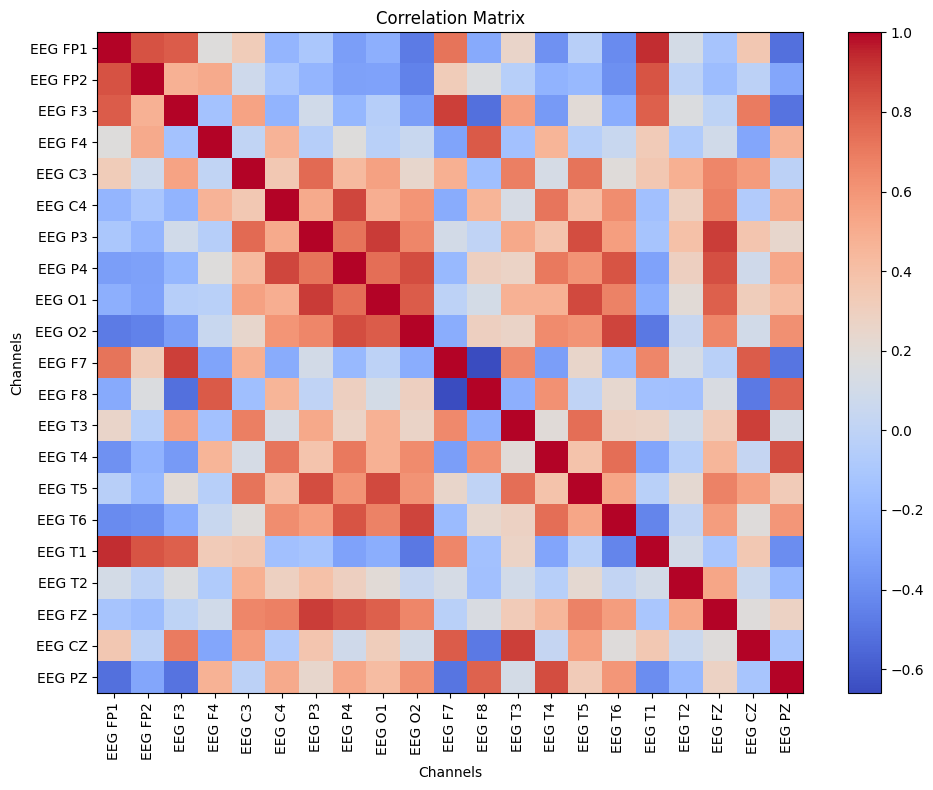

In [23]:
# Standardize the data
X_train_standardized = standardize_data(X_train)
print(f"Standardized output shape: {X_train_standardized.shape}")
# Expected shape: (len(raw_files), 12, 21, 1250)
# Compute the correlation matrix per sample, segment, and channel

corr_matrix_train = compute_correlation_matrix(X_train_standardized)
print(f"Correlation matrix shape: {corr_matrix_train.shape}")
# Expected shape: (21, 21)
# Display the correlation matrix
plt.figure(figsize=(10, 8)) 
plt.imshow(corr_matrix_train[0][11], cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xlabel('Channels')
plt.ylabel('Channels')
plt.xticks(range(len(eeg_cols)), eeg_cols, rotation=90)
plt.yticks(range(len(eeg_cols)), eeg_cols)
plt.tight_layout()
plt.show()



# Example usage
upper_triangle_matrix_train = extract_upper_triangle(corr_matrix_train)



In [24]:
# Standardize the data
X_test_standardized = standardize_data(X_test)
print(f"Standardized output shape: {X_test_standardized.shape}")
print(f"# of nan values : {np.isnan(X_test_standardized).sum()}")
# Expected shape: (len(raw_files), 12, 21, 1250)
# Compute the correlation matrix per sample, segment, and channel

corr_matrix_test = compute_correlation_matrix(X_test_standardized)
print(f"Correlation matrix shape: {corr_matrix_test.shape}")
print(f"# of nan values : {np.isnan(corr_matrix_test).sum()}")
# Expected shape: (21, 21)

# Example usage
upper_triangle_matrix_test = extract_upper_triangle(corr_matrix_test)

print(upper_triangle_matrix_test.shape)

Standardized output shape: (144, 12, 21, 1250)
# of nan values : 0
Correlation matrix shape: (144, 12, 21, 21)
# of nan values : 0
(144, 12, 210)


/Users/zac/.pyenv/versions/3.11.8/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zac/.pyenv/versions/3.11.8/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [25]:
X_test_standardized.shape, corr_matrix_test.shape

((144, 12, 21, 1250), (144, 12, 21, 21))

In [26]:
print(np.isnan(X_test_standardized).sum())

print(np.isnan(corr_matrix_test).sum())

0
0


In [27]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(upper_triangle_matrix_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True )

X_test_tensor = torch.tensor(upper_triangle_matrix_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
# Create TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [28]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([583, 12, 210])
torch.Size([144, 12, 210])
torch.Size([583])
torch.Size([144])


In [29]:
next(iter(train_loader))[0].max()

tensor(1.)

## Load & transform Data

In [30]:
next(iter(test_loader))[0].max()

tensor(0.9972)

In [31]:
print(next(iter(test_loader))[0])

tensor([[[ 9.4423e-01,  9.1334e-01,  7.8896e-01,  ...,  2.1491e-01,
          -7.6273e-01, -6.1478e-02],
         [ 9.4423e-01,  9.1334e-01,  7.8896e-01,  ...,  2.1491e-01,
          -7.6273e-01, -6.1478e-02],
         [ 9.4423e-01,  9.1334e-01,  7.8896e-01,  ...,  2.1491e-01,
          -7.6273e-01, -6.1478e-02],
         ...,
         [ 9.4423e-01,  9.1334e-01,  7.8896e-01,  ...,  2.1491e-01,
          -7.6273e-01, -6.1478e-02],
         [ 9.4423e-01,  9.1334e-01,  7.8896e-01,  ...,  2.1491e-01,
          -7.6273e-01, -6.1478e-02],
         [ 9.4423e-01,  9.1334e-01,  7.8896e-01,  ...,  2.1491e-01,
          -7.6273e-01, -6.1478e-02]],

        [[ 8.8840e-01,  9.3231e-01,  6.7986e-01,  ...,  1.4475e-02,
          -7.3548e-01,  1.3098e-01],
         [ 8.8840e-01,  9.3231e-01,  6.7986e-01,  ...,  1.4475e-02,
          -7.3548e-01,  1.3098e-01],
         [ 8.8840e-01,  9.3231e-01,  6.7986e-01,  ...,  1.4475e-02,
          -7.3548e-01,  1.3098e-01],
         ...,
         [ 8.8840e-01,  9

### Model Definition

Epoch 1/1000, LR: 0.000010, Train Loss: 0.6499, Val Loss: 0.6604, Val Accuracy: 63.89%
Epoch 2/1000, LR: 0.000010, Train Loss: 0.6589, Val Loss: 0.6583, Val Accuracy: 63.89%
Epoch 3/1000, LR: 0.000010, Train Loss: 0.6390, Val Loss: 0.6564, Val Accuracy: 63.89%
Epoch 4/1000, LR: 0.000010, Train Loss: 0.6380, Val Loss: 0.6545, Val Accuracy: 63.89%
Epoch 5/1000, LR: 0.000010, Train Loss: 0.6536, Val Loss: 0.6528, Val Accuracy: 63.89%
Epoch 6/1000, LR: 0.000010, Train Loss: 0.6340, Val Loss: 0.6516, Val Accuracy: 63.89%
Epoch 7/1000, LR: 0.000010, Train Loss: 0.6243, Val Loss: 0.6505, Val Accuracy: 63.89%
Epoch 8/1000, LR: 0.000010, Train Loss: 0.6345, Val Loss: 0.6493, Val Accuracy: 63.89%
Epoch 9/1000, LR: 0.000010, Train Loss: 0.6197, Val Loss: 0.6483, Val Accuracy: 63.89%
Epoch 10/1000, LR: 0.000010, Train Loss: 0.6410, Val Loss: 0.6475, Val Accuracy: 63.89%
Epoch 11/1000, LR: 0.000010, Train Loss: 0.6240, Val Loss: 0.6467, Val Accuracy: 63.89%
Epoch 12/1000, LR: 0.000010, Train Loss: 

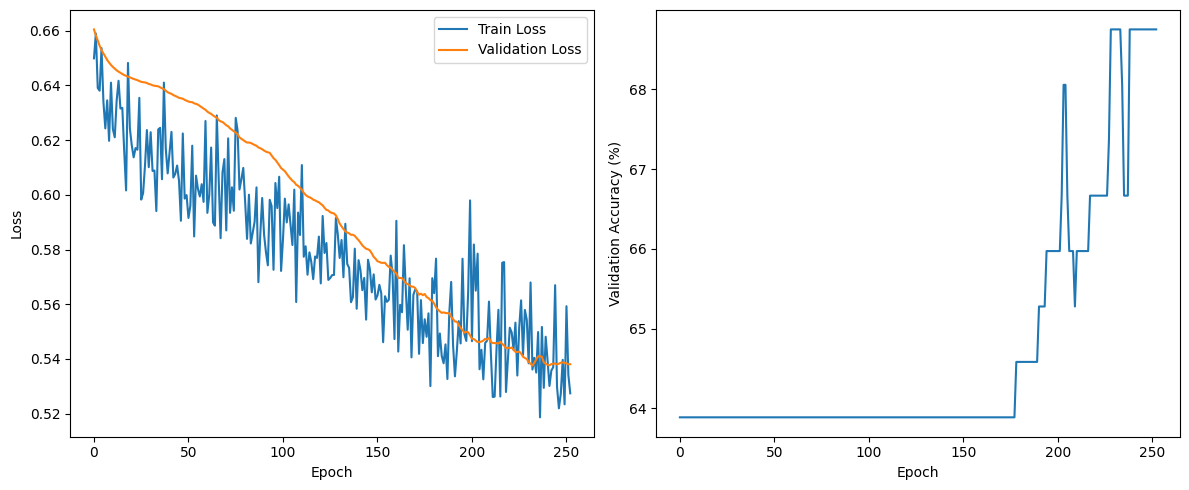

In [39]:
importlib.reload(EpilepsyNet_model)

# Model parameters
input_dim = 210  # Size of flattened upper triangle (21*20/2)
embed_dim = 56  # Embedding dimension
num_heads = 7    # Number of attention heads

model = EpilepsyNet_model.TimeSeriesAttentionClassifier(input_dim, embed_dim, num_heads, dropout=0.2)
# MLFLow tracking

# # Train the model
# train_losses, val_losses, val_accuracies = EpilepsyNet_model.train_model(
#     model, train_loader, test_loader, num_epochs=100, learning_rate=1e-5
# )


train_losses, val_losses, val_accuracies = EpilepsyNet_model.train_model(
    model, 
    train_loader, 
    test_loader,
    num_epochs=1000,
    learning_rate=1e-5,
    weight_decay=1e-5,
    patience=10,
    scheduler_factor=0.5,
    min_lr=1e-6
)

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.tight_layout()
plt.show()

# Visualize attention for a sample
# visualize_attention(model, X_standardized)

In [34]:
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(1, 150),
    y=train_losses,
    mode='lines+markers',
    name='Train Loss'
))
fig.add_trace(go.Scatter(
    x=np.arange(1, 150),
    y=val_losses,
    mode='lines+markers',
    name='Validation Loss'
))
fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    legend_title='Legend'
)
fig.show()

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate F1 score, sensitivity (recall), and precision.

    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels

    Returns:
    - metrics: Dictionary containing F1 score, sensitivity, and precision
    """
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Sensitivity

    metrics = {
        'F1 Score': f1,
        'Precision': precision,
        'Sensitivity (Recall)': recall
    }
    return metrics

# Example usage
y_pred, _ = model(torch.tensor(next(iter(test_loader))))#, dtype=torch.float32)).argmax(dim=1).numpy()
metrics = calculate_metrics(y_test, y_pred)
print(metrics)

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
parameters = {
        'eeg_cols':eeg_cols,
        'segment_duration':60.0,        # 60 second segments
        'n_segments_per_file':12,       # Split into 12 epochs (5 sec each)
        'samples_per_segment':1250,     # 1250 samples per segment (250 Hz sampling rate)
        'random_state':42  
        }


paths = [
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t005.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t011.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t010.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t004.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t012.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t006.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t007.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t009.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaamnj/s012_2016/01_tcp_ar/aaaaamnj_s012_t008.edf',
        'EEG_Epilepsy/00_epilepsy/aaaaanwn/s003_2014/01_tcp_ar/aaaaanwn_s003_t001.edf',
    ]
    
    # paths = [
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaamey/s001_2011/02_tcp_le/aaaaamey_s001_t000.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaapkt/s001_2013/01_tcp_ar/aaaaapkt_s001_t000.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaapkt/s001_2013/01_tcp_ar/aaaaapkt_s001_t001.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaaocx/s001_2012/01_tcp_ar/aaaaaocx_s001_t000.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaaooz/s001_2013/01_tcp_ar/aaaaaooz_s001_t000.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s001_2011/02_tcp_le/aaaaalpi_s001_t004.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s001_2011/02_tcp_le/aaaaalpi_s001_t002.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s001_2011/02_tcp_le/aaaaalpi_s001_t003.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s001_2011/02_tcp_le/aaaaalpi_s001_t001.edf',
    #         'EEG_Epilepsy/01_no_epilepsy/aaaaalpi/s002_2011/02_tcp_le/aaaaalpi_s002_t001.edf'
    #         ]



def process_raw_files2(raw_file: mne.io.Raw, 
                      eeg_cols: List[str],
                      segment_duration: float = 60.0,
                      n_segments_per_file: int = 12,
                      samples_per_segment: int = 1250,
                      random_state: Optional[int] = None) -> np.ndarray:
    """
    Process a list of raw MNE files into a batch of epochs with specific EEG channels.
    
    Parameters:
    -----------
    raw_files : mne.io.Raw
        The raw MNE object to make preds on
    eeg_cols : List[str]
        List of EEG channel names to keep
    segment_duration : float
        Duration of random segment to extract from each file in seconds
    n_segments_per_file : int
        Number of segments to create per file
    samples_per_segment : int
        Number of time samples per segment
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    np.ndarray
        Array of shape (len(raw_files), n_segments_per_file, len(eeg_cols), samples_per_segment)
    """
    # Initialize the output array
    X = np.zeros((n_segments_per_file, len(eeg_cols), samples_per_segment))
    
    # Define duration of each epoch based on number of segment and total duration
    epoch_duration = segment_duration / n_segments_per_file
    

    try:
        # Set different random seed for each file if random_state is provided
        file_random_state = None if random_state is None else random_state
        
        # Pick only the specified EEG channels
        available_channels = raw_file.ch_names
        print('Num of availbable ch :', len(available_channels))
        channels_to_use = [ch for ch in eeg_cols if ch.replace('-REF','').replace('-LE','') in eeg_cols]
        if not channels_to_use:
            raise ValueError(f"None of the specified EEG channels found in file")
        
        if len(channels_to_use) < len(eeg_cols):
            print(f"Warning: Only {len(channels_to_use)}/{len(eeg_cols)} EEG channels found in file")
            
        # Select only the required channels
        raw_eeg = raw_file.copy().pick_channels(channels_to_use)
        
        # Resample to 250Hz
        current_sfreq = int(raw_eeg.info['sfreq'])
        if current_sfreq != 250:
            print(f"🔁 Resample : {current_sfreq} Hz → {250} Hz")
            raw_eeg.resample(250)
            
        # Extract random segment
        raw_segment = extract_random_segment(
            raw_eeg, 
            duration=segment_duration,
            random_state=file_random_state
        )
        
        # Convert to epochs
        epochs = segment_to_epochs(raw_segment, n_segments=n_segments_per_file)
        
        # Get the data as array
        epoch_data = epochs.get_data()
        
        # Ensure the data has the correct number of time samples
        if epoch_data.shape[2] != samples_per_segment:
            # Resample if necessary
            resampling_freq = samples_per_segment / (epoch_duration / n_segments_per_file)
            raw_segment.resample(resampling_freq)
            epochs = segment_to_epochs(raw_segment, n_segments=n_segments_per_file)
            epoch_data = epochs.get_data()
        
        # Store in the output array
        X[:, :len(channels_to_use), :] = epoch_data
        
    except Exception as e:
        print(f"Error processing file {str(e)}")
        # Keep zeros in the output array for this file
    
    return X
predictions, probas = [], []
for path in paths:
    raw = mne.io.read_raw_edf(path,
                            preload=True,
                            verbose='ERROR')
    X = process_raw_files2(
        raw_file=raw,
        eeg_cols=eeg_cols,
        segment_duration=parameters['segment_duration'],
        n_segments_per_file=parameters['n_segments_per_file'],
        random_state=parameters['random_state']
        )

    X_std = standardize_data(X)
    corr_matrix = compute_correlation_matrix(X_std)
    # print('Correlation matrix shape :',corr_matrix.shape)

    upper_triangle_matrix = extract_upper_triangle(corr_matrix)
    # print('Upper Triangle shape :',upper_triangle_matrix.shape)

    X_tensor = torch.tensor(upper_triangle_matrix, dtype=torch.float32)
    X_tensor = X_tensor.unsqueeze(0)
    

    print('¨'*50)
    print('Model Prediction :')
    output, logits = model(X_tensor)
    proba, predicted = torch.max(output, 1)
    print('output',output)
    probas.append(proba)
    print(int(predicted))
    print('¨'*50)
    predictions.append(int(predicted))
    print(probas)
print(predictions)

Num of availbable ch : 31
Error processing file None of the specified EEG channels found in file


AxisError: axis 3 is out of bounds for array of dimension 3

In [ ]:
# Add to inference : matrix list attention score (210x210) giving correlation p

In [37]:
# Save model locally:
torch.save(model.state_dict(), 'EpilepsyNet.pth')

In [ ]:
# Load th model:
model = TimeSeriesAttentionClassifier(input_dim, embed_dim, num_heads)
model.load_state_dict(torch.load('EpilepsyNet.pth'))
model.eval()
